# Presentado por *Diego de la Cruz Sandoval*
marzo 2024

# Variables consideradas
- Facturación mensual
- Caracteristicas socioeconómicas de la zona:
	- Coeficiente de Gini
	- Tasa de Desempleo
	- Ingreso Promedio
- Densidad poblacional
- Número de competidores en la zona
- Infraestructura cercana:
	- Estaciones de autobus
	- Centros educativos
	- Iglesias



# Fuentes de Información
- Registros Duplicados
- Inconsistencia en registros repetidos (185/204)
- Datos incompletos en el archivo de PDV propios:
	- Geolocalización
	- Datos socioeconómicos
- Densidad de tráfico/flujo peatonal
- Datos climáticos
- Preferencias de compra/tendencias de consumo


In [3]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler

### EDA

In [2]:
directorio = "/Users/diego/Desktop/Development/Python/pronaca/Assessment/BDD.xlsx"
df_pdv = pd.read_excel(directorio, sheet_name='BDD PDV')
df_competencia = pd.read_excel(directorio, sheet_name='BDD Competencia')
df_extrapolar = pd.read_excel(directorio, sheet_name='BDD Extrapolar')

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [23]:
df_pdv_n = df_pdv.loc[
	(df_pdv['Prom vta mensual'].notna()) & (df_pdv['Prom vta mensual'] != 0) &
	(df_pdv['Ticket promedio'].notna()) & (df_pdv['Ticket promedio'] != 0) &
	(df_pdv['Coef_gini'].notna()) & (df_pdv['Coef_gini'] != 0) &
	(df_pdv['Poblacion'].notna()) & (df_pdv['Poblacion'] != 0) &
	(df_pdv['Codigo Identificativo PDV'].notna()) & (df_pdv['Codigo Identificativo PDV'] != 0), 
	[
		'Codigo Identificativo PDV',
		'Provincia',
		'A_Población',
		'B_Población',
		'C+_Población',
		'C-_Población',
		'D_Población',
		'Poblacion',
		'Prom vta mensual',
		'Cant Transacciones',
		'Ticket promedio',
		'Coef_gini',
		'Estación de bus',
		'Centro educativo',
		'Iglesias']]

df_pdv_n = df_pdv_n.drop_duplicates(
    subset=['Codigo Identificativo PDV'], keep=False)

df_pdv_n2 = df_pdv_n.copy()

# Asumo que si estos valores están vacíos, no existe este tipo de infraestructura. No puedo hacer lo mismo con las otras variables seleccionadas.
revision = ['Estación de bus', 'Centro educativo', 'Iglesias']

for rev in revision:
	df_pdv_n2[rev] = df_pdv_n2[rev].fillna(0)

In [24]:
df_pdv_n2.head()

,Codigo Identificativo PDV,Provincia,A_Población,B_Población,C+_Población,C-_Población,D_Población,Poblacion,Prom vta mensual,Cant Transacciones,Ticket promedio,Coef_gini,Estación de bus,Centro educativo,Iglesias
0,A04703,GUAYAS,208.0,2098.0,6601.0,9818.0,3476.0,6937.63830,2549.0,486.0,13.0,0.42120,0.0,0.0,0.0
2,S38775,PICHINCHA,241.0,3364.0,9267.0,12234.0,2559.0,8644.93340,4038.0,540.0,24.0,0.29194,0.0,3.0,0.0
3,S30940,PICHINCHA,631.0,4299.0,4562.0,4012.0,813.0,4474.00065,8598.0,996.0,22.0,0.29194,0.0,3.0,0.0
4,S38A54,PICHINCHA,29.0,726.0,2998.0,5094.0,1025.0,3085.08535,5081.0,927.0,17.0,0.49055,3.0,0.0,0.0
5,5S0S34,MANABÍ,342.0,2742.0,5822.0,6149.0,902.0,4986.53380,3780.0,512.0,18.0,0.39651,0.0,0.0,0.0


# Algoritmos

## *Regresion Lineal**
Predice una variable continua, facturación.

Error Cuadrático Medio: 51414273.93031395
Coeficiente de Determinación: 0.024131035213032614


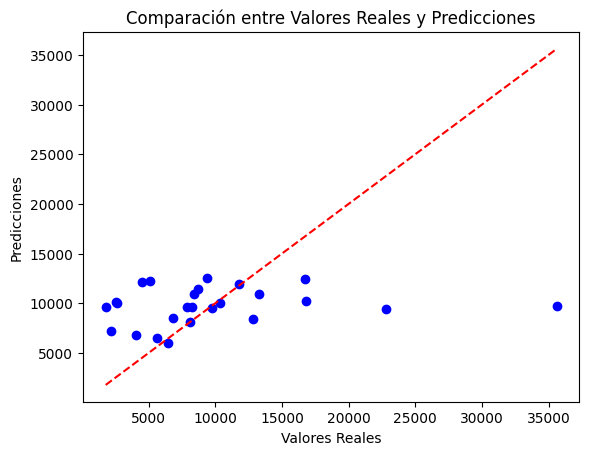

In [26]:
# Preparación de los datos
X = df_pdv_n2[['Poblacion', 'Coef_gini', 'Estación de bus', 'Centro educativo', 'Iglesias']]
y = df_pdv_n2['Prom vta mensual']

# División de datos: entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=34)

# Entrenamiento
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Evaluación
y_pred = modelo.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)
print("Error Cuadrático Medio:", mse)
print("Coeficiente de Determinación:", r2)

plt.scatter(y_test, y_pred, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(),y_test.max()], color='red', linestyle='--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.show()

### Conclusión
- De acuerdo al resultado del error cuadrático medio y el coeficiente de determinación; el modelo no explica bien la variabilidad de los datos, es decir, las variables seleccionadas y el modelo de regresión lineal no son capaces de predecir la facturación promedio de manera efectiva.
- Así mismo, de manera gráfica, los puntos azules deberían estar rodeando la linea roja, lo cual no sucede; por lo tanto, nuevamente mostramos que el modelo no está ajustado y falta precisiónn en las predicciones.

## *K-Means*
Genera grupos según el desempeño

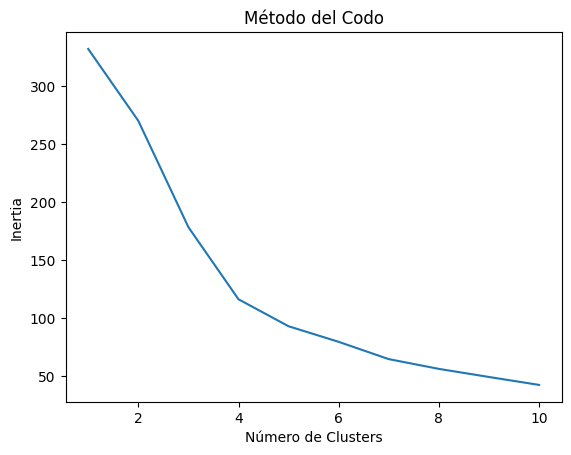

In [74]:
from sklearn.cluster import KMeans

caracteristicas_pdv = df_pdv_n2[['Poblacion', 'Prom vta mensual', 'Cant Transacciones', 'Ticket promedio']]

# Ajustamos la distribución de los datos. Nos aseguramos que cada caracteristica tenga un peso similar en el cálculo de distancias.
scaler = StandardScaler()
caracteristicas_esc = scaler.fit_transform(caracteristicas_pdv)

# Primer intento
# Método del codo
inertia = []
for k in range(1, 11):
	kmeans = KMeans(n_clusters=k, random_state=65)
	kmeans.fit(caracteristicas_esc)
	inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia)
plt.title('Método del Codo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.show()

De acuerdo al gráfico anterior, observamos que el punto -4- disminuye la inercia, y a partir de este no hay mejora en la calidad de los clusters.

In [75]:
k_optimo = 4
kmeans1 = KMeans(n_clusters=k_optimo, random_state=84)
kmeans1.fit(caracteristicas_esc)

KMeans(n_clusters=4, random_state=84)

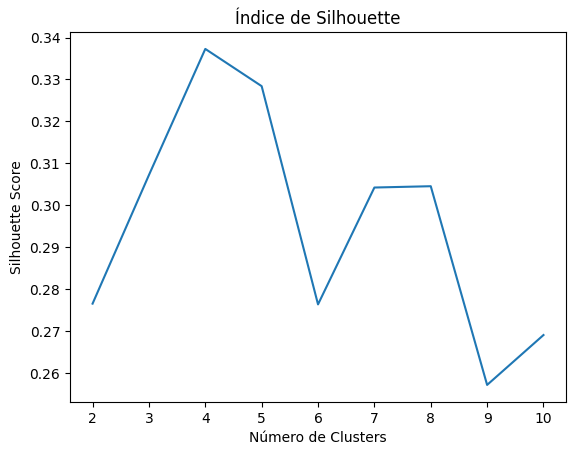

In [79]:
from sklearn.metrics import silhouette_score

# Índice de Silhouette
silhouette_scores = []
for k in range(2, 11):
	kmeans = KMeans(n_clusters=k, random_state=112)
	kmeans.fit(caracteristicas_esc)
	score = silhouette_score(caracteristicas_esc, kmeans.labels_)
	silhouette_scores.append(score)

plt.plot(range(2, 11), silhouette_scores)
plt.title('Índice de Silhouette')
plt.xlabel('Número de Clusters')
plt.ylabel('Silhouette Score')
plt.show()

Para el índice de silhouette, debemos fijarnos en el pico más alto, -2-.

In [80]:
k_optimo = 4
kmeans2 = KMeans(n_clusters=k_optimo, random_state=34)
kmeans2.fit(caracteristicas_esc)

KMeans(n_clusters=4, random_state=34)

In [82]:
clusters_pdv1 = kmeans1.fit_predict(caracteristicas_pdv)
clusters_pdv1

array([2, 2, 0, 0, 0, 3, 2, 0, 0, 0, 2, 0, 2, 2, 0, 2, 2, 1, 0, 0, 1, 0,
       0, 0, 1, 2, 1, 0, 1, 0, 2, 2, 3, 2, 2, 2, 1, 1, 0, 0, 1, 0, 1, 2,
       0, 2, 0, 2, 1, 1, 1, 1, 2, 1, 3, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2,
       1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 2, 2, 1, 2, 2, 0, 1], dtype=int32)

In [83]:
clusters_pdv2 = kmeans2.fit_predict(caracteristicas_pdv)
clusters_pdv2

array([3, 3, 0, 0, 0, 1, 3, 0, 0, 3, 3, 0, 3, 3, 0, 3, 3, 2, 0, 0, 2, 0,
       0, 0, 2, 3, 2, 0, 2, 0, 3, 3, 1, 3, 3, 3, 2, 2, 0, 2, 2, 0, 2, 3,
       0, 3, 0, 3, 2, 2, 2, 2, 3, 2, 1, 2, 3, 3, 3, 0, 2, 2, 2, 0, 2, 3,
       2, 0, 0, 0, 2, 0, 0, 0, 0, 3, 3, 3, 2, 3, 3, 0, 2], dtype=int32)

In [ ]:
caracteristicas_loc = df_extrapolar[['Poblacion', '']]

In [69]:
# Asigno grupos a los datos
df_pdv_n2['clusters_pdv1'] = clusters_pdv1
# df_pdv_n2['clusters_pdv2'] = clusters_pdv2

df_pdv_n2.groupby(['clusters_pdv1']).count()

,Codigo Identificativo PDV,Provincia,A_Población,B_Población,C+_Población,C-_Población,D_Población,Poblacion,Prom vta mensual,Cant Transacciones,Ticket promedio,Coef_gini,Estación de bus,Centro educativo,Iglesias,clusters_pdv,clusters_pdv2
clusters_pdv1,,,,,,,,,,,,,,,,,
0,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28,28
1,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23,23
2,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29,29
3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [70]:
# df_pdv_n2.groupby(['clusters_pdv2']).count()

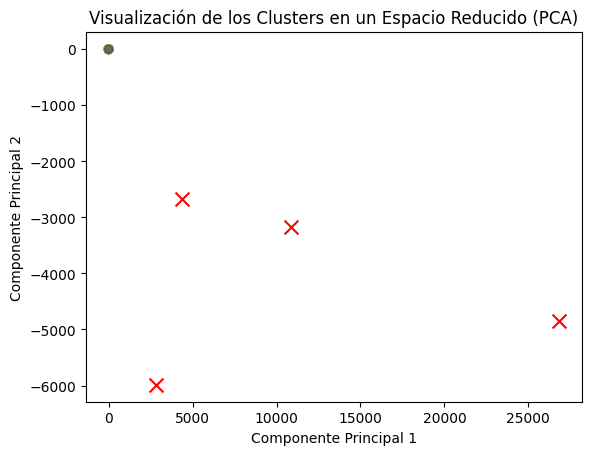

In [71]:
from sklearn.decomposition import PCA

# Analizo los resultados: interpretamos los grupos
pca = PCA(n_components = 2)
caracteristicas_pca = pca.fit_transform(caracteristicas_esc)
centroides = kmeans1.cluster_centers_
centroides_pca = pca.transform(centroides)

plt.scatter(caracteristicas_pca[:, 0], caracteristicas_pca[:,1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(centroides_pca[:, 0],centroides_pca[:, 1], marker='x', s=100, c='red')
plt.title('Visualización de los Clusters en un Espacio Reducido (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

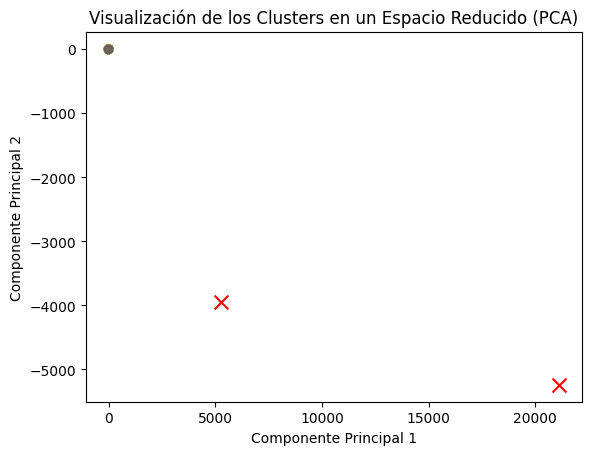

In [72]:
from sklearn.decomposition import PCA

# Analizo los resultados: interpretamos los grupos
pca = PCA(n_components = 2)
caracteristicas_pca = pca.fit_transform(caracteristicas_esc)
centroides = kmeans2.cluster_centers_
centroides_pca = pca.transform(centroides)

plt.scatter(caracteristicas_pca[:, 0], caracteristicas_pca[:,1], c=kmeans.labels_, cmap='viridis', alpha=0.5)
plt.scatter(centroides_pca[:, 0],centroides_pca[:, 1], marker='x', s=100, c='red')
plt.title('Visualización de los Clusters en un Espacio Reducido (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

### Conclusión
- Las coordenadas no proporcionan suficiente contexto para comprender la distribución de los puntos de venta.

### Recomendaciones
- Ejecutar un mayor escalamiento de datos, partiendo de un conjunto de datos más grande.